In [1]:
# -*- encoding:utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import astropy
from astropy.io import fits
from pyquaternion import Quaternion
# from astropy import units as u
from astropy.coordinates import solar_system_ephemeris
from astropy.coordinates import SkyCoord
file1 = '1910061313_1910061328.fits'
file2 = '00342_191006sun.fits'
fits1 = fits.open(file1)
fits1h0 = fits1[1].data
fits1h1 = fits1[2].data
fits1h2 = fits1[3].data
fits1h3 = fits1[4].data
fits2 = fits.open(file2) 
fits2h = fits2[1].data


In [2]:
t = fits2h['t']
Q0 = fits2h['Q0']
Q1 = fits2h['Q1']
Q2 = fits2h['Q2']
Q3 = fits2h['Q3']
sXcel = fits2h['s_X_cel']
sYcel = fits2h['s_Y_cel']
sZcel = fits2h['s_Z_cel']
sRacel = fits2h['s_Ra_cel']
sDeccel = fits2h['s_Dec_cel']
gXcel = fits2h['g_X_cel']
gYcel = fits2h['g_Y_cel']
gZcel = fits2h['g_Z_cel']
gRacel = fits2h['g_Ra_cel']
gDeccel = fits2h['g_Dec_cel']
sXdet = fits2h['s_X_det']
sYdet = fits2h['s_Y_det']
sZdet = fits2h['s_Z_det']
sRadet = fits2h['s_Ra_det']
sDecdet = fits2h['s_Dec_det']
t0 = fits1h0['t0']
t1 = fits1h1['t1']
t2 = fits1h2['t2']
t3 = fits1h3['t3']

In [3]:
sunXYZdet = np.zeros((len(t),3))

for i in tqdm(range(len(t))):
    Q = Quaternion(Q0[i], Q1[i], Q2[i], Q3[i])
    scel = np.array([sXcel[i], sYcel[i], sZcel[i]])
    scel = scel / np.linalg.norm(scel)
    sdet = Q.inverse.rotate(scel)
    sunXYZdet[i] = sdet

gXYZcel = np.zeros((len(t),3))
for i in tqdm(range(len(t))):
    Q = Quaternion(Q0[i], Q1[i], Q2[i], Q3[i])
    gXYZcel[i] = Q.rotate(np.array([0.0,0.0,-1.0]))



100%|██████████| 4354/4354 [00:00<00:00, 11951.88it/s]


In [4]:
%matplotlib notebook
def arccos2(x,y):
    if x==0 and y==0:
        return 0
    elif x>0 and y==0:
        return 0
    elif x<0 and y==0:
        return np.pi
    elif x==0 and y>0:
        return np.pi/2
    elif x==0 and y<0:
        return np.pi/2*3
    elif x>0 and y>0:
        return np.arccos(x/np.sqrt(x**2+y**2))
    elif x<0 and y>0:
        return np.arccos(x/np.sqrt(x**2+y**2))
    elif x<0 and y<0:
        return 2*np.pi-np.arccos(x/np.sqrt(x**2+y**2))
    elif x>0 and y<0:
        return 2*np.pi-np.arccos(x/np.sqrt(x**2+y**2))
arccos2 = np.vectorize(arccos2)   
gRacel1 = arccos2(gXYZcel[:,0],gXYZcel[:,1])    
gDeccel1 = np.arcsin(gXYZcel[:,2])
sRadet1 = arccos2(sunXYZdet[:,0],sunXYZdet[:,1])
sDecdet1 = np.arcsin(sunXYZdet[:,2])


In [5]:
# 确认函数
def absmax(a,b):
    return np.abs(a-b).max()


# 确认太阳在探测器坐标系下的指向向量是否正确
print(absmax(sunXYZdet[:,0],sXdet),absmax(sunXYZdet[:,1],sYdet),absmax(sunXYZdet[:,2],sZdet))
# 确认探测器法线在GCRS的指向向量是否正确
print(absmax(gXYZcel[:,0],gXcel),absmax(gXYZcel[:,1],gYcel),absmax(gXYZcel[:,2],gZcel))
# 确认太阳在探测器坐标系下的赤经和赤纬是否正确
print(absmax(sRadet1,sRadet),absmax(sDecdet1,sDecdet))
# 确认探测器法线在GCRS的赤经和赤纬是否正确
print(absmax(gRacel1,gRacel),absmax(gDeccel1,gDeccel))

4.440892098500626e-16 5.551115123125783e-16 4.440892098500626e-16
6.661338147750939e-16 6.661338147750939e-16 6.661338147750939e-16
1.6991323712606254e-13 9.103828801926284e-15
6.343710279299586e-14 1.7541523789077473e-14


In [6]:
sRadet2 = arccos2(sXdet,sYdet)
sDecdet2 = np.arcsin(sZdet)
# 确认赤经和赤纬的计算方法
print(absmax(sRadet2,sRadet),absmax(sDecdet2,sDecdet))

5.0297775926883e-13 4.884981308350689e-15


In [7]:
hdr = fits.Header()
col00 = fits.Column(name = 't',         format = 'D', unit = 's', array = t)
col01 = fits.Column(name = 'Q0',        format = 'D', unit = '1', array = Q0)
col02 = fits.Column(name = 'Q1',        format = 'D', unit = '1', array = Q1)
col03 = fits.Column(name = 'Q2',        format = 'D', unit = '1', array = Q2)
col04 = fits.Column(name = 'Q3',        format = 'D', unit = '1', array = Q3)
col05 = fits.Column(name = 'my_g_X_cel',   format = 'D', unit = '1', array = gXYZcel[:, 0])
col06 = fits.Column(name = 'my_g_Y_cel',   format = 'D', unit = '1', array = gXYZcel[:, 1])
col07 = fits.Column(name = 'my_g_Z_cel',   format = 'D', unit = '1', array = gXYZcel[:, 2])
col08 = fits.Column(name = 'my_g_Ra_cel',  format = 'D', unit = 'rad', array = gRacel1)
col09 = fits.Column(name = 'my_g_Dec_cel', format = 'D', unit = 'rad', array = gDeccel1)
col10 = fits.Column(name = 'g_X_cel',      format = 'D', unit = '1',   array = gXcel)
col11 = fits.Column(name = 'g_Y_cel',      format = 'D', unit = '1',   array = gYcel)
col12 = fits.Column(name = 'g_Z_cel',      format = 'D', unit = '1',   array = gZcel)
col13 = fits.Column(name = 'my_s_X_det',   format = 'D', unit = '1', array = sunXYZdet[:, 0])
col14 = fits.Column(name = 'my_s_Y_det',   format = 'D', unit = '1', array = sunXYZdet[:, 1])
col15 = fits.Column(name = 'my_s_Z_det',   format = 'D', unit = '1', array = sunXYZdet[:, 2])
col16 = fits.Column(name = 'my_s_Ra_det',  format = 'D', unit = 'rad', array = sRadet1)
col17 = fits.Column(name = 'my_s_Dec_det', format = 'D', unit = 'rad', array = sDecdet1)
hduc_0 = fits.BinTableHDU.from_columns([col00, col01, col02, col03, 
                                        col04, col05, col06, col07, 
                                        col08, col09, col10, col11, 
                                        col12, col13, col14, col15,
                                        col16, col17], name='radec', header=hdr)
hdu0 = fits.PrimaryHDU()
hdu_list = fits.HDUList([hdu0, hduc_0])
hdu_list.writeto('sun-gxf.fits', overwrite=True)

In [8]:
hdr = fits.Header()
col00 = fits.Column(name = 't',         format = 'D', unit = 's', array = t)
col01 = fits.Column(name = 'Q0',        format = 'D', unit = '1', array = Q0)
col02 = fits.Column(name = 'Q1',        format = 'D', unit = '1', array = Q1)
col03 = fits.Column(name = 'Q2',        format = 'D', unit = '1', array = Q2)
col04 = fits.Column(name = 'Q3',        format = 'D', unit = '1', array = Q3)
col05 = fits.Column(name = 'my_g_X_cel',   format = 'D', unit = '1', array = gXYZcel[:, 0])
col06 = fits.Column(name = 'my_g_Y_cel',   format = 'D', unit = '1', array = gXYZcel[:, 1])
col07 = fits.Column(name = 'my_g_Z_cel',   format = 'D', unit = '1', array = gXYZcel[:, 2])
col08 = fits.Column(name = 'g_X_cel',      format = 'D', unit = '1',   array = gXcel)
col09 = fits.Column(name = 'g_Y_cel',      format = 'D', unit = '1',   array = gYcel)
col10 = fits.Column(name = 'g_Z_cel',      format = 'D', unit = '1',   array = gZcel)
col11 = fits.Column(name = 'my_s_X_det',   format = 'D', unit = '1', array = sunXYZdet[:, 0])
col12 = fits.Column(name = 'my_s_Y_det',   format = 'D', unit = '1', array = sunXYZdet[:, 1])
col13 = fits.Column(name = 'my_s_Z_det',   format = 'D', unit = '1', array = sunXYZdet[:, 2])
col14 = fits.Column(name = 'my_s_Ra_det',  format = 'D', unit = 'rad', array = sRadet1)
col15 = fits.Column(name = 'my_s_Dec_det', format = 'D', unit = 'rad', array = sDecdet1)
hduc_0 = fits.BinTableHDU.from_columns([col00, col01, col02, col03, 
                                        col04, col05, col06, col07, 
                                        col08, col09, col10, col11, 
                                        col12, col13, col14, col15], name='radec', header=hdr)
hdu0 = fits.PrimaryHDU()
hdu_list = fits.HDUList([hdu0, hduc_0])
hdu_list.writeto('sun.fits', overwrite=True)

In [9]:
sun = fits.open("sun.fits")
sun.info()

Filename: sun.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  RADEC         1 BinTableHDU     57   4354R x 16C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


<IPython.core.display.Javascript object>


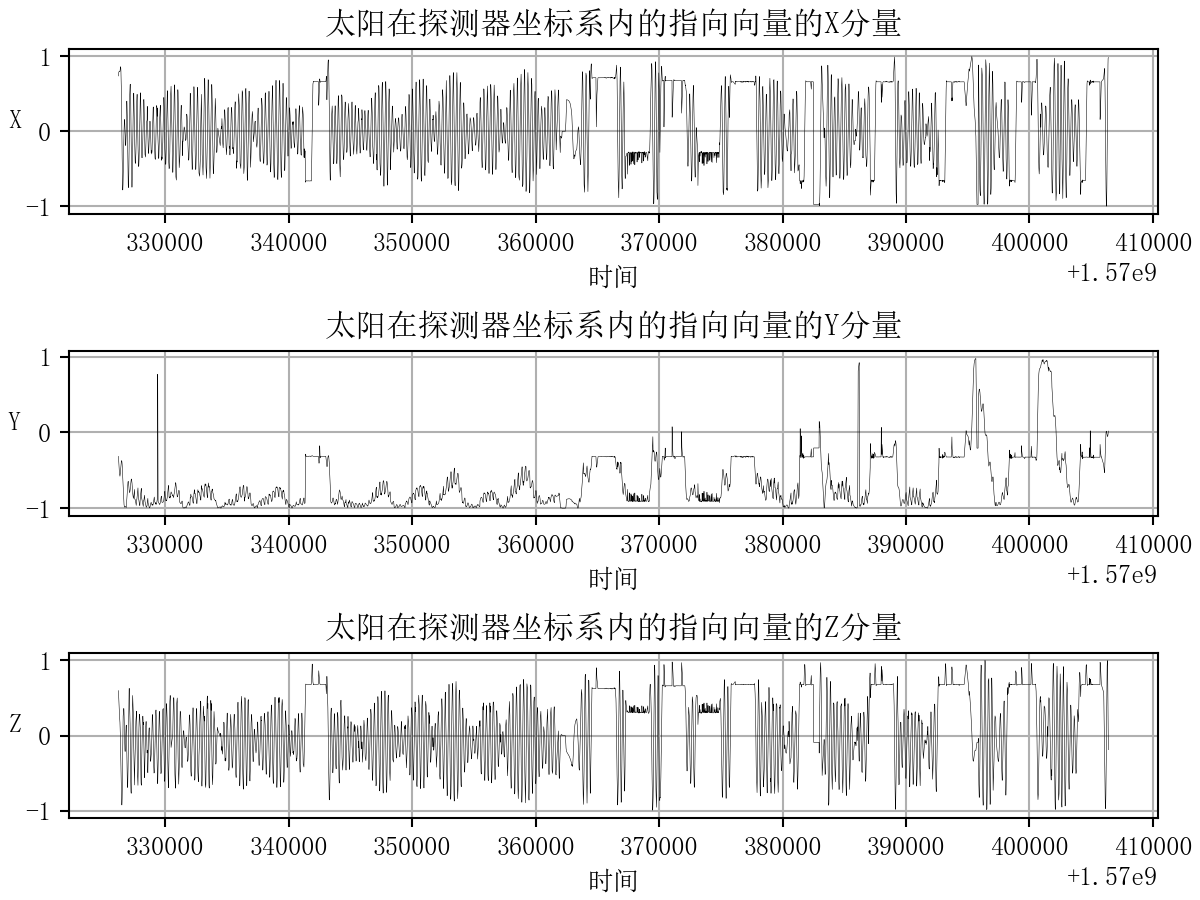

In [10]:
plt.rcParams['font.sans-serif']=['SimSun']
plt.rcParams['axes.unicode_minus'] = False
fig, axes = plt.subplots(3, 1, dpi=150,constrained_layout=True)
axes[0].plot(t,sunXYZdet[:,0],linewidth=0.2,color='black')
axes[0].set_title(r'太阳在探测器坐标系内的指向向量的X分量')
axes[0].set_xlabel(r'时间')
axes[0].set_ylabel(r'X',rotation=0)
axes[0].grid()

axes[1].plot(t,sunXYZdet[:,1],linewidth=0.2,color='black')
axes[1].set_title(r'太阳在探测器坐标系内的指向向量的Y分量')
axes[1].set_xlabel(r'时间')
axes[1].set_ylabel(r'Y',rotation=0)
axes[1].grid()

axes[2].plot(t,sunXYZdet[:,2],linewidth=0.2,color='black')
axes[2].set_title(r'太阳在探测器坐标系内的指向向量的Z分量')
axes[2].set_xlabel(r'时间')
axes[2].set_ylabel(r'Z',rotation=0)
axes[2].grid()


fig.savefig('太阳在探测器坐标系内的指向向量.png')

<IPython.core.display.Javascript object>


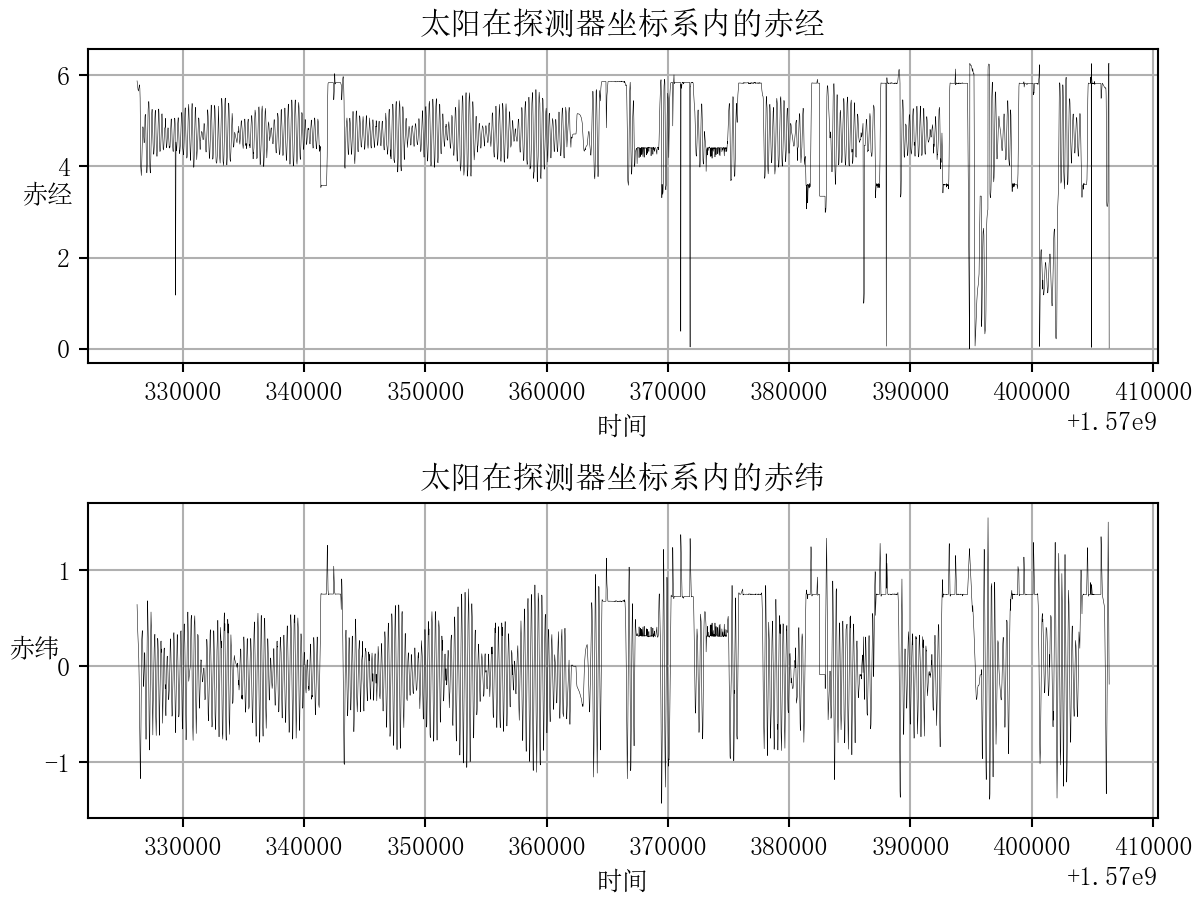

In [11]:
plt.rcParams['font.sans-serif']=['SimSun']
plt.rcParams['axes.unicode_minus'] = False
fig, axes = plt.subplots(2, 1, dpi=150,constrained_layout=True)
axes[0].plot(t,sRadet1,linewidth=0.2,color='black')
axes[0].set_title(r'太阳在探测器坐标系内的赤经')
axes[0].set_xlabel(r'时间')
axes[0].set_ylabel(r'赤经',rotation=0)
axes[0].grid()

axes[1].plot(t,sDecdet1,linewidth=0.2,color='black')
axes[1].set_title(r'太阳在探测器坐标系内的赤纬')
axes[1].set_xlabel(r'时间')
axes[1].set_ylabel(r'赤纬',rotation=0)
axes[1].grid()
fig.savefig('太阳在探测器坐标系内的赤经赤纬.png')

In [12]:
def get_mask(t,delta_t):
    mask = []
    t1 = t[0]
    while t1  < t[-1]:
        mask1 = (t>=t1-delta_t)&(t<t1+delta_t)
        mask.append(mask1)
        t1 = t1 + 2*delta_t
    return mask 


def time_point(t,delta_t):
    time1 = []
    t1 = t[0]
    while t1  < t[-1]:
        time1.append(t1)
        t1 = t1 + 2*delta_t
    return time1

In [13]:
mask0 = get_mask(t0,0.4)
t01 = time_point(t0,0.4)
light0 = np.array([a.sum() for a in mask0])/0.8

mask1 = get_mask(t1,0.4)
t11 = time_point(t1,0.4)
light1 = np.array([a.sum() for a in mask1])/0.8

mask2 = get_mask(t2,0.4)
t21 = time_point(t2,0.4)
light2 = np.array([a.sum() for a in mask2])/0.8

mask3 = get_mask(t3,0.4)
t31 = time_point(t3,0.4)
light3 = np.array([a.sum() for a in mask3])/0.8

<IPython.core.display.Javascript object>


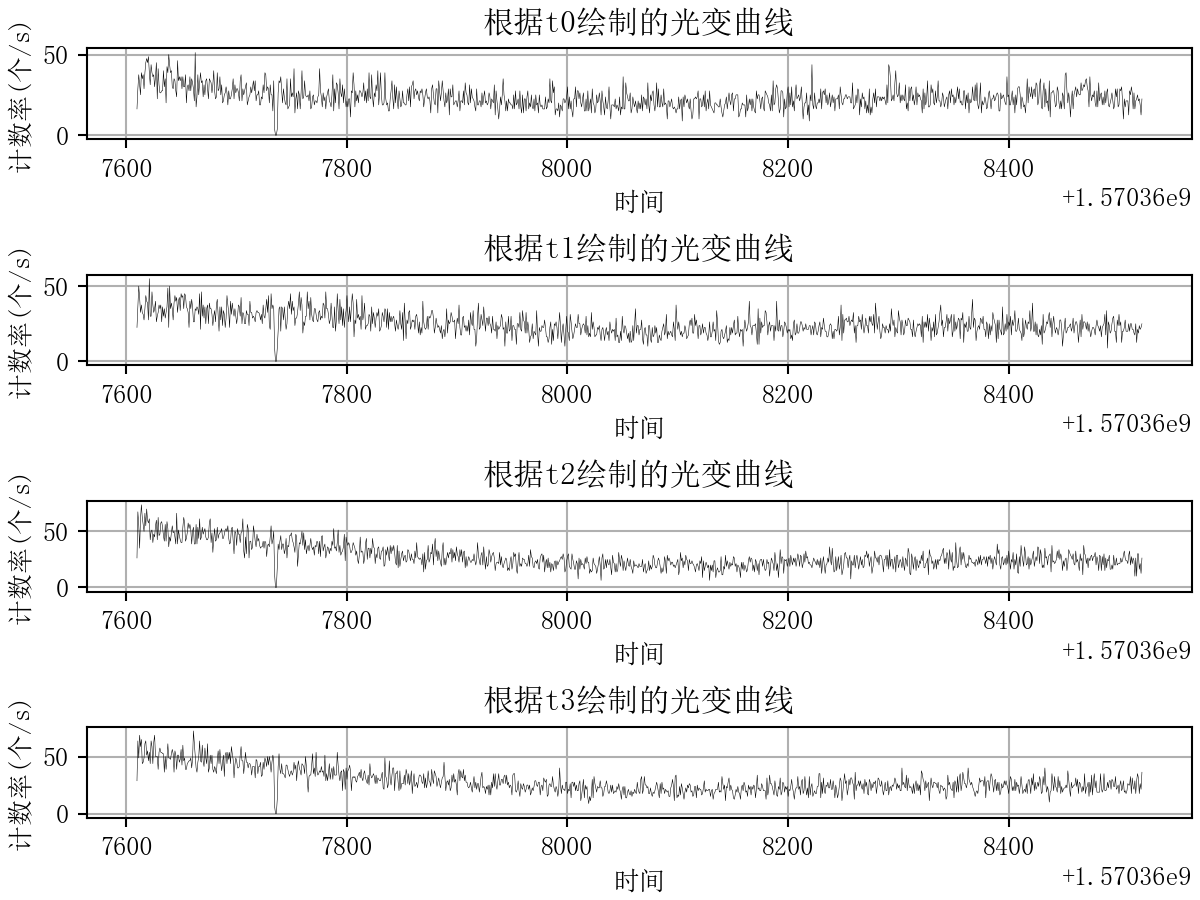

In [23]:
plt.rcParams['font.sans-serif']=['SimSun']
plt.rcParams['axes.unicode_minus'] = False
fig, axes = plt.subplots(4, 1, dpi=150,constrained_layout=True)
axes[0].plot(t01,light0,linewidth=0.2,color='black')
axes[0].set_title(r'根据t0绘制的光变曲线')
axes[0].set_xlabel(r'时间')
axes[0].set_ylabel(r'计数率(个/s)')
axes[0].grid()

axes[1].plot(t11,light1,linewidth=0.2,color='black')
axes[1].set_title(r'根据t1绘制的光变曲线')
axes[1].set_xlabel(r'时间')
axes[1].set_ylabel(r'计数率(个/s)')
axes[1].grid()

axes[2].plot(t21,light2,linewidth=0.2,color='black')
axes[2].set_title(r'根据t2绘制的光变曲线')
axes[2].set_xlabel(r'时间')
axes[2].set_ylabel(r'计数率(个/s)')
axes[2].grid()

axes[3].plot(t31,light3,linewidth=0.2,color='black')
axes[3].set_title(r'根据t3绘制的光变曲线')
axes[3].set_xlabel(r'时间')
axes[3].set_ylabel(r'计数率(个/s)')
axes[3].grid()
fig.savefig('光变曲线.png')